<a href="https://colab.research.google.com/github/b-karthiknair/pinn-optimization-cs4240-2024/blob/main/group_23/analysis/fermat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reimplementation of PINN to solve Fermat's Principle using JAX

In [1]:
!pip install jax jaxlib flax optax



In [2]:
import jax
import jax.numpy as jnp

from flax import linen as nn
import optax
import matplotlib.pyplot as plt
import numpy as np
from jax import config as jax_config
jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision

#Attempt 1:
First attempt, tried changing the weights to make the network tuned cause it does not meet the boundary conditions. The modelling of the loss function might be wrong. T trained in the neural network.

In [3]:


class LightPathNN(nn.Module):
    def setup(self):
        self.n_output = 2  # Number of output dimensions
        self.T = self.param('T', jax.nn.initializers.ones, (1,))

    @nn.compact
    def __call__(self, t):
        t = jnp.reshape(t, (-1, 1))
        x = t
        for _ in range(3):
            x = nn.Dense(128)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.n_output, kernel_init=jax.nn.initializers.glorot_normal())(x)
        x = nn.sigmoid(x)  # Apply sigmoid activation to the output
        return x

def model_derivative(t, params):
    def x_derivative(t):
        x_output = model.apply({'params': params}, t)[:, 0]
        return jnp.sum(x_output)
    def y_derivative(t):
        y_output = model.apply({'params': params}, t)[:, 1]
        return jnp.sum(y_output)
    x_t = jax.grad(x_derivative)(jnp.reshape(t, -1))
    y_t = jax.grad(y_derivative)(jnp.reshape(t, -1))
    return x_t, y_t

def ode_loss_fn(params, t, T, x0, y0, x1, y1):

    t = jnp.reshape(t, (-1, 1))

    preds = model.apply({'params': params}, t)
    x, y = preds[:, 0:1], preds[:, 1:2]

    x_t, y_t = model_derivative(t, params)
    n1, n2, c0 = 1., 2., 1.

    refraction = n1 + (n2 - n1) * 0.5 * (1. - jnp.cos(2. * jnp.pi * y))
    vel = c0 / refraction
    ode1 = x_t ** 2 + y_t ** 2 - vel ** 2
    ode2 = T - 1.0

    bc_loss_start =  ((x[0] - x0)**2 + (y[0] - y0)**2)  #boundary conditions
    bc_loss_end =  ((x[-1] - x1)**2 + (y[-1] - y1)**2)

    loss_weights = [1., 1, 0.1, 1.]

    total_loss = loss_weights[0]*jnp.mean(ode1**2) + loss_weights[1]*jnp.mean(ode2**2) + loss_weights[2]*bc_loss_start + loss_weights[2]*bc_loss_end

    return total_loss

# Initialize the model and optimizer
model = LightPathNN()
key = jax.random.PRNGKey(0)
key, init_key = jax.random.split(key)
# Initialize model parameters
init_values = model.init(init_key, jnp.ones((1, 1)))
init_params = init_values['params']
# Initialize model with the original key
params = model.init(key, jnp.ones((1, 1)))['params']

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, batch, T, x0, y0, x1, y1):
    def loss_fn(params, batch, T, x0, y0, x1, y1):
        return jnp.sum(ode_loss_fn(params, batch["t"], T, x0, y0, x1, y1))
    grads_fn = jax.grad(loss_fn, argnums=0)
    grads = grads_fn(params, batch, T, x0, y0, x1, y1)
    loss = ode_loss_fn(params, batch["t"], T, x0, y0, x1, y1)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# Training loop with the correct arguments passed
num_domain = 1000
tmin, tmax = 0.0, 1.0
T = 1.0
x0, y0, x1, y1 = 0., 0., 1., 1.  # Boundary conditions

for epoch in range(2000):
    t = jnp.linspace(tmin, tmax, num_domain).reshape(-1, 1)
    batch = {"t": t}
    params, opt_state, loss = train_step(params, opt_state, batch, T, x0, y0, x1, y1)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

t_plot = jnp.linspace(tmin, tmax, 101).reshape(-1, 1)
uu = model.apply({'params': params}, t_plot)


Epoch 0, Loss: [0.17142341]
Epoch 100, Loss: [0.03875345]
Epoch 200, Loss: [0.03853027]
Epoch 300, Loss: [0.03842843]
Epoch 400, Loss: [0.0384879]
Epoch 500, Loss: [0.03834215]
Epoch 600, Loss: [0.03831503]
Epoch 700, Loss: [0.03829311]
Epoch 800, Loss: [0.0382746]
Epoch 900, Loss: [0.03827479]
Epoch 1000, Loss: [0.03825096]
Epoch 1100, Loss: [0.03824304]
Epoch 1200, Loss: [0.0382377]
Epoch 1300, Loss: [0.0382345]
Epoch 1400, Loss: [0.03823097]
Epoch 1500, Loss: [0.0382282]
Epoch 1600, Loss: [0.03822803]
Epoch 1700, Loss: [0.0382242]
Epoch 1800, Loss: [0.03822213]
Epoch 1900, Loss: [0.03822052]


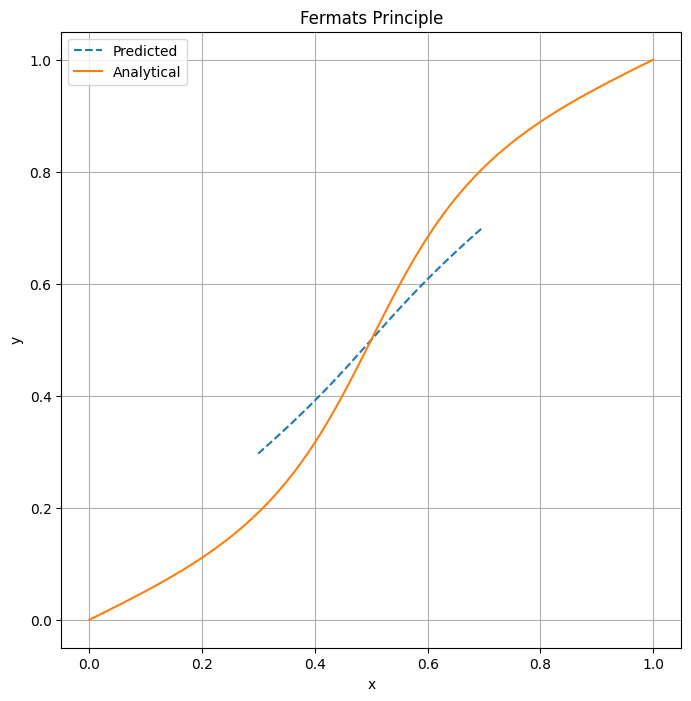

In [5]:
plt.figure(figsize=(8, 8))
plt.plot(uu[:, 0], uu[:, 1], label='Predicted', linestyle='--')

#actual path followed acc to fermats -- analytical solution
yy = np.linspace(0, 1, 101)
xx = np.arctan(2. * np.tan(np.pi * yy)) / np.pi
xx[len(xx) // 2 + 1:] += 1
plt.plot(xx, yy, label='Analytical')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fermats Principle')
plt.legend()
plt.grid()
plt.show()

#Attempt 2:
Fixed the loss function and it's able to meet the boundary conditions now but cannot match the analytical solution. The hyperparams provided in the original implementation might be causing the issue because changing slightly them in the deepxde implementation tends to cause significant deviations.

In [9]:

from jax import random, grad


class LightPathNN(nn.Module):
    def setup(self):
        self.n_output = 2  # Number of output dimensions
        # Define T as a trainable parameter
        self.T = self.param('T', lambda key, shape: jax.random.uniform(key, shape), (1,))

    @nn.compact
    def __call__(self, inputs):

        x = jnp.reshape(inputs, (-1, 1))  # Ensuring input is a column vector

        # Defining the hidden layers with tanh activation
        for _ in range(3):  # Three hidden layers
            x = nn.Dense(64)(x)
            x = nn.tanh(x)

        x = nn.Dense(self.n_output)(x)

        x = jnp.concatenate([x[:, :1], nn.sigmoid(x[:, 1:])], axis=1)

        return x

# def model_derivative(t, params):
#     def x_derivative(t):
#         x_output = model.apply({'params': params}, t)[:, 0]
#         return jnp.sum(x_output)
#     def y_derivative(t):
#         y_output = model.apply({'params': params}, t)[:, 1]
#         return jnp.sum(y_output)
#     x_t = grad(x_derivative)(jnp.reshape(t, -1))
#     y_t = grad(y_derivative)(jnp.reshape(t, -1))
#     return x_t, y_t

def model_derivative(model, params, t):

    def output_component(i):
        def model_i_output(t):
            x = model.apply({'params': params}, t)[:, i]
            return jnp.mean(x)  # This ensures scalar output
        return model_i_output

    # Compute the gradient with respect to t for both outputs individually
    grad_fn_x = grad(output_component(0))(t)
    grad_fn_y = grad(output_component(1))(t)

    # Assuming T is fetched from the parameters and reshaped to ensure it's a scalar
    T = jnp.reshape(params['T'], ())  # Ensure T is treated as a scalar

    dx_dt_scaled = grad_fn_x / T
    dy_dt_scaled = grad_fn_y / T

    return dx_dt_scaled, dy_dt_scaled


def ode_loss_fn(params, t, T, x0, y0, x1, y1):
    t = jnp.reshape(t, (-1, 1))
    preds = model.apply({'params': params}, t)
    x, y = preds[:, 0:1], preds[:, 1:2]
    x_t, y_t = model_derivative(model, params,t)
    n1, n2, c0 = 1., 2., 1.
    refraction = n1 + (n2 - n1) * 0.5 * (1. - jnp.cos(2. * jnp.pi * y))
    vel = c0 / refraction
    ode1 = x_t ** 2 + y_t ** 2 - vel ** 2
    ode2 = T * jnp.ones_like(x)  # Scale the output by T
    bc_loss_start = ((x[0] - x0)**2 + (y[0] - y0)**2)  # Boundary conditions
    bc_loss_end = ((x[-1] - x1)**2 + (y[-1] - y1)**2)
    loss_weights = [1, 1., 0.01, 1.]
    total_loss = loss_weights[0] * jnp.mean(ode1**2) + loss_weights[1] * jnp.mean(ode2**2) + loss_weights[2] * bc_loss_start + loss_weights[2] * bc_loss_end
    return total_loss

# Initialize the model and optimizer
model = LightPathNN()
key = random.PRNGKey(0)
key, init_key = random.split(key)
init_key, params_key = random.split(init_key)
init_params = model.init(params_key, jnp.ones((1, 1)))  # Initialize other parameters
params = model.init(params_key, jnp.ones((1, 1)))['params']
optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, batch, T, x0, y0, x1, y1):
    def loss_fn(params, batch, T, x0, y0, x1, y1):
        return jnp.sum(ode_loss_fn(params, batch["t"], T, x0, y0, x1, y1))
    grads_fn = jax.grad(loss_fn, argnums=0)
    grads = grads_fn(params, batch, T, x0, y0, x1, y1)
    loss = ode_loss_fn(params, batch["t"], T, x0, y0, x1, y1)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# Training loop with the correct arguments passed
num_domain = 1000
tmin, tmax = 0.0, 1.0
x0, y0, x1, y1 = 0., 0., 1., 1.  # Boundary conditions

# Access the T parameter using the correct key
T_params = init_params['params']['T']

for epoch in range(2000):
    t = jnp.linspace(tmin, tmax, num_domain).reshape(-1, 1)
    batch = {"t": t}
    params, opt_state, loss = train_step(params, opt_state, batch, T_params, x0, y0, x1, y1)  # Pass T from init_params
    if epoch % 100 == 0:
        T_value = params['T']
        print(T_value)
        print(f"Epoch {epoch}, Loss: {loss}")

t_plot = jnp.linspace(tmin, tmax, 101).reshape(-1, 1)
uu = model.apply({'params': params}, t_plot)


[0.84289817]
Epoch 0, Loss: [0.79080526]
[0.74577009]
Epoch 100, Loss: [0.77860252]
[0.61328239]
Epoch 200, Loss: [0.77833356]
[0.42774997]
Epoch 300, Loss: [0.77819196]
[0.12284712]
Epoch 400, Loss: [0.77800868]
[0.00295652]
Epoch 500, Loss: [0.71617594]
[0.00733732]
Epoch 600, Loss: [0.73467033]
[0.00235754]
Epoch 700, Loss: [0.71321967]
[0.00227408]
Epoch 800, Loss: [0.71241218]
[0.0033238]
Epoch 900, Loss: [0.71646414]
[0.00255501]
Epoch 1000, Loss: [0.71291369]
[0.00248159]
Epoch 1100, Loss: [0.71244241]
[0.00248025]
Epoch 1200, Loss: [0.7120416]
[0.002516]
Epoch 1300, Loss: [0.71186318]
[0.00258564]
Epoch 1400, Loss: [0.71182465]
[0.00263207]
Epoch 1500, Loss: [0.71180339]
[0.00268649]
Epoch 1600, Loss: [0.71183044]
[0.00274143]
Epoch 1700, Loss: [0.71176511]
[0.00282833]
Epoch 1800, Loss: [0.71216881]
[0.0028329]
Epoch 1900, Loss: [0.71174657]


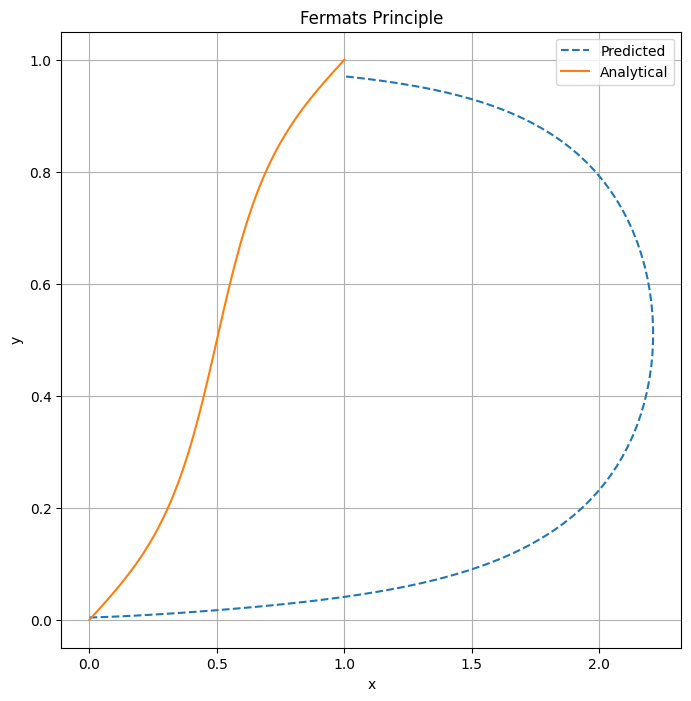

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(uu[:, 0], uu[:, 1], label='Predicted', linestyle='--')

#actual path followed acc to fermats -- analytical solution
yy = np.linspace(0, 1, 101)
xx = np.arctan(2. * np.tan(np.pi * yy)) / np.pi
xx[len(xx) // 2 + 1:] += 1
plt.plot(xx, yy, label='Analytical')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fermats Principle')
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 971.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 5.8 MB/s eta 0:00:00
